In [1]:
# Import libraries
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

import unicodedata
import re
import string
import joblib 
import pickle as pickle

In [2]:
# nltk.download('punkt')
# pip install unidecode
from unidecode import unidecode

In [3]:
# Load data
data_train = pd.read_csv('../../Data Splits/train_data_80_20.csv')
data_val = pd.read_csv('../../Data Splits/val_data_80_20.csv')

In [4]:
X_train = data_train['article']
y_train = data_train['label']

X_val = data_val['article']
y_val = data_val['label']

In [5]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.preprocess(text) for text in X]

    def preprocess(self, text):
        # print(textes)
        text = str(text)
        text = text.lower()
        normalized = unicodedata.normalize("NFD", text)
        text = "".join(c for c in normalized if unicodedata.category(c) != "Mn")
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r"\\W", " ", text)
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'<.*?>+', '', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\n', '', text)
        text = re.sub(r'\w*\d\w*', '', text)
        return text

In [6]:
#create StopWords
stopwords = pd.read_json('../../Datasets/stopwords-tl.json')
custom_stop_words = stopwords[0].values.tolist()

In [7]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']

Metrics for MNB:
Accuracy: 0.8509532062391681
Precision: 0.7811634349030471
Recall: 0.9757785467128027
F1 Score: 0.8676923076923077
AUC: 0.9761149557862361
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.73      0.83       288
           1       0.78      0.98      0.87       289

    accuracy                           0.85       577
   macro avg       0.87      0.85      0.85       577
weighted avg       0.87      0.85      0.85       577



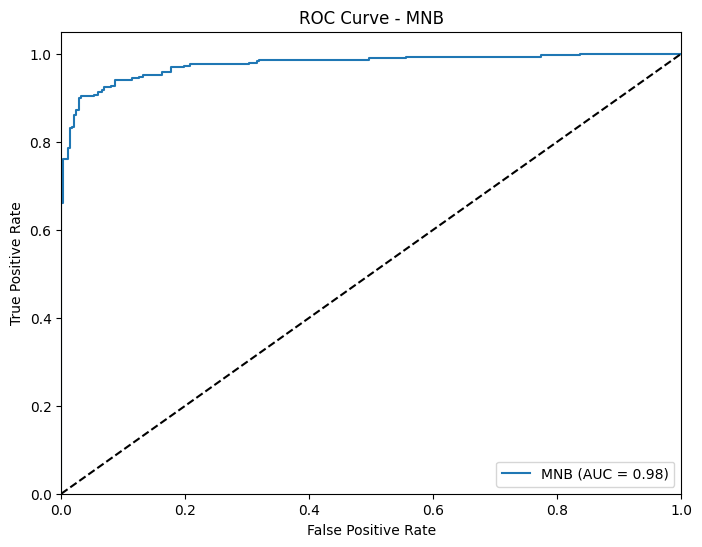

Metrics for LR:
Accuracy: 0.9480069324090121
Precision: 0.9743589743589743
Recall: 0.9204152249134948
F1 Score: 0.9466192170818505
AUC: 0.9884779892349096
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       288
           1       0.97      0.92      0.95       289

    accuracy                           0.95       577
   macro avg       0.95      0.95      0.95       577
weighted avg       0.95      0.95      0.95       577



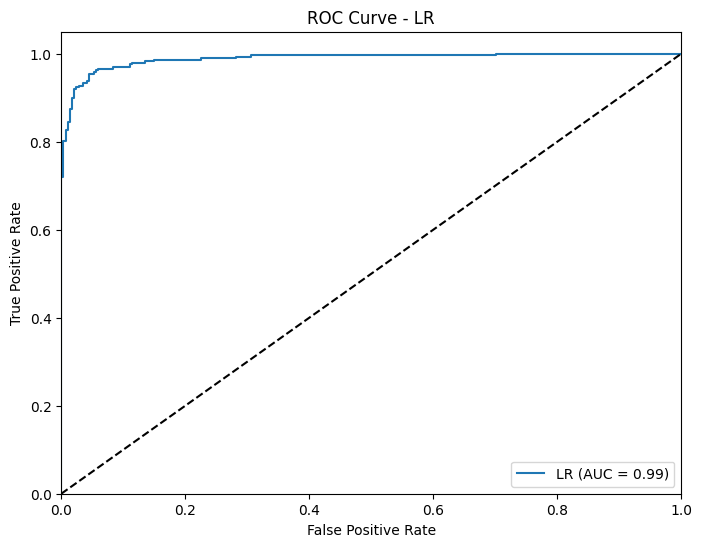

Metrics for RF:
Accuracy: 0.9445407279029463
Precision: 0.9605734767025089
Recall: 0.9273356401384083
F1 Score: 0.9436619718309859
AUC: 0.9891508073817762
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       288
           1       0.96      0.93      0.94       289

    accuracy                           0.94       577
   macro avg       0.95      0.94      0.94       577
weighted avg       0.95      0.94      0.94       577



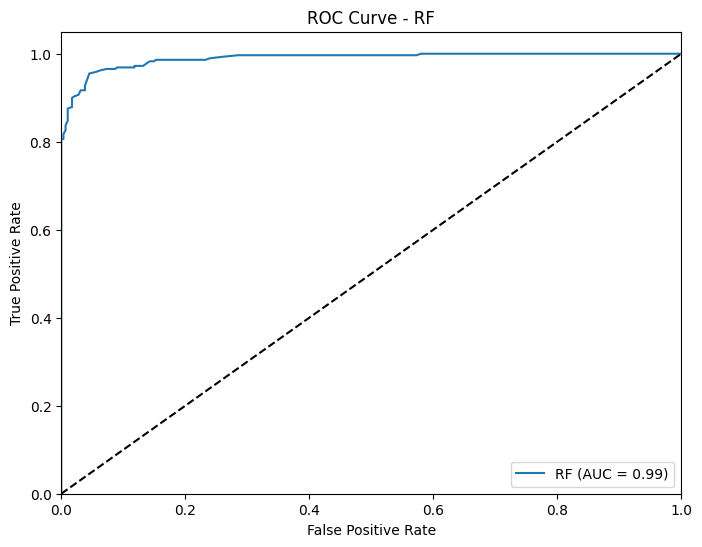

Metrics for KNN:
Accuracy: 0.8596187175043327
Precision: 0.8095238095238095
Recall: 0.9411764705882353
F1 Score: 0.8704
AUC: 0.948871828143022
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       288
           1       0.81      0.94      0.87       289

    accuracy                           0.86       577
   macro avg       0.87      0.86      0.86       577
weighted avg       0.87      0.86      0.86       577



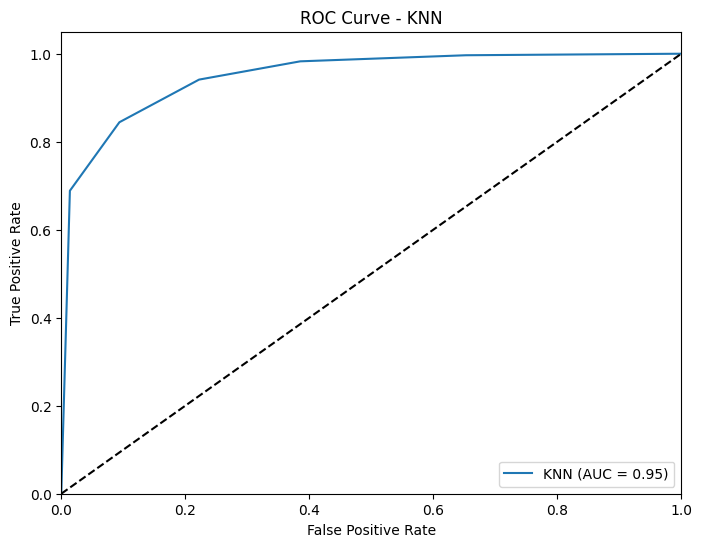

Metrics for SVM:
Accuracy: 0.9549393414211439
Precision: 0.9816849816849816
Recall: 0.9273356401384083
F1 Score: 0.9537366548042705
AUC: 0.9922265474817378
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       288
           1       0.98      0.93      0.95       289

    accuracy                           0.95       577
   macro avg       0.96      0.95      0.95       577
weighted avg       0.96      0.95      0.95       577



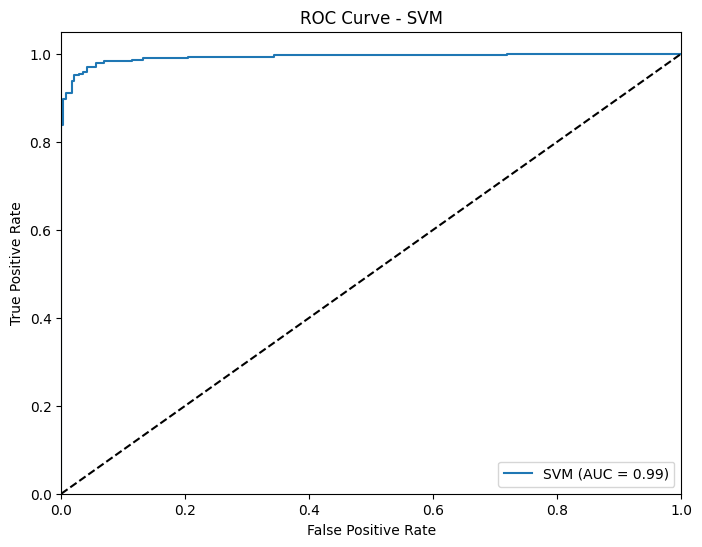

In [8]:
stack = joblib.load('../../Models/80-20 Test/pipeline_mlp.joblib')

# Create an empty DataFrame for storing metrics
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# Use TFIDF inside of stacking to vectorize X_val(Evaluation)
vectorized_text = stack.named_steps['vectorizer'].transform(X_val)

# Evaluate base models
for model, name in  zip(stack.named_steps['stacking'].estimators_ , base_names):
    y_pred = model.predict(vectorized_text)
    y_prob = model.predict_proba(vectorized_text)[:, 1]  # Probability for positive class for ROC curve
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(y_val, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = roc_auc_score(y_val, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

Metrics for Stacking Model:
Accuracy: 0.9618717504332756
Precision: 0.968421052631579
Recall: 0.9550173010380623
F1 Score: 0.9616724738675958
AUC: 0.9946414840445983
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       288
           1       0.97      0.96      0.96       289

    accuracy                           0.96       577
   macro avg       0.96      0.96      0.96       577
weighted avg       0.96      0.96      0.96       577



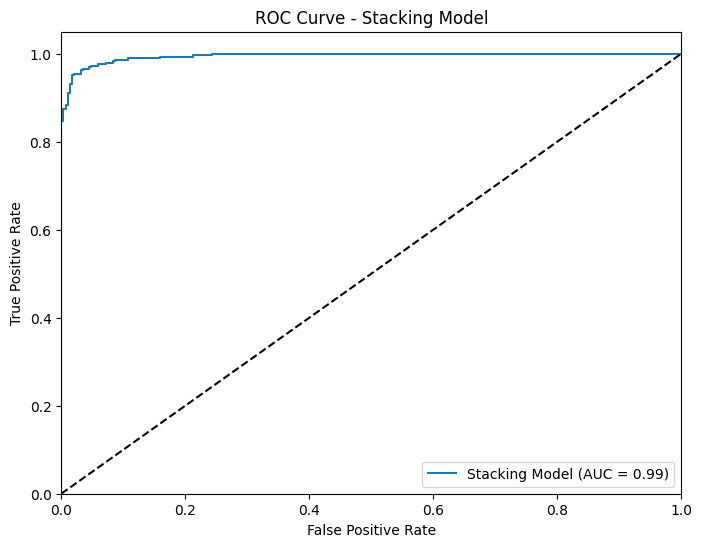

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB             0.850953  0.781163  0.975779  0.867692  0.976115
LR              0.948007  0.974359  0.920415  0.946619  0.988478
RF              0.944541  0.960573  0.927336  0.943662  0.989151
KNN             0.859619  0.809524  0.941176    0.8704  0.948872
SVM             0.954939  0.981685  0.927336  0.953737  0.992227
Stacking Model  0.961872  0.968421  0.955017  0.961672  0.994641


In [9]:
# Evaluate stacking model
stack_y_pred = stack.predict(X_val)
stack_y_prob = stack.predict_proba(X_val)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(y_val, stack_y_pred)
stack_precision = precision_score(y_val, stack_y_pred)
stack_recall = recall_score(y_val, stack_y_pred)
stack_f1 = f1_score(y_val, stack_y_pred)
stack_auc = roc_auc_score(y_val, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(y_val, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_val, stack_y_prob)
stack_roc_auc = roc_auc_score(y_val, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)